SAC的简化版实现,alpha使用常量代替.只使用一个value模型,而不是两个.

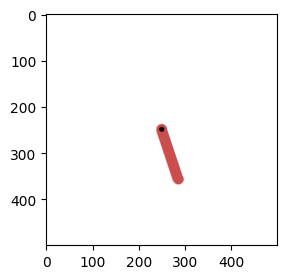

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class ModelAction(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
        self.sigma = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        state = self.s(state)
        return self.mu(state), self.sigma(state).exp()


model_action = ModelAction()

model_action(torch.randn(2, 3))

(tensor([[-0.2374],
         [-0.2333]], grad_fn=<TanhBackward0>),
 tensor([[0.9357],
         [0.9717]], grad_fn=<ExpBackward0>))

In [3]:
model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(2, 4))

tensor([[0.0019],
        [0.0052]], grad_fn=<AddmmBackward0>)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #根据概率采样
        mu, sigma = model_action(torch.FloatTensor(state).reshape(1, 3))
        action = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

72.2250243315433

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

len(pool), pool[0]

/tmp/ipykernel_19891/3624659836.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(200,
 (array([0.63902766, 0.76918375, 0.10462173], dtype=float32),
  -0.45079428593689985,
  0.903496999558007,
  array([0.6177828 , 0.7863488 , 0.54627126], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.995 + _from.data * 0.005
        _to.data.copy_(value)


def get_action_entropy(state):
    mu, sigma = model_action(torch.FloatTensor(state).reshape(-1, 3))
    dist = torch.distributions.Normal(mu, sigma)

    action = dist.rsample()
    entropy = dist.log_prob(action) - (1 - action.tanh()**2 + 1e-8).log()
    entropy = -entropy

    return action, entropy


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [7]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_value, True)
    requires_grad(model_action, False)

    #计算target
    with torch.no_grad():
        #计算动作和熵
        next_action, entropy = get_action_entropy(next_state)

        #评估next_state的价值
        input = torch.cat([next_state, next_action], dim=1)
        target = model_value_next(input)

    #加权熵,熵越大越好
    target = target + 5e-3 * entropy
    target = target * 0.99 * (1 - over) + reward

    #计算value
    value = model_value(torch.cat([state, action], dim=1))

    loss = torch.nn.functional.mse_loss(value, target)

    loss.backward()
    optimizer_value.step()
    optimizer_value.zero_grad()

    return loss.item()


train_value(state, action, reward, next_state, over)

0.4308680295944214

In [8]:
def train_action(state):
    requires_grad(model_value, False)
    requires_grad(model_action, True)

    #计算action和熵
    action, entropy = get_action_entropy(state)

    #计算value
    value = model_value(torch.cat([state, action], dim=1))

    #加权熵,熵越大越好
    loss = -(value + 5e-3 * entropy).mean()

    #使用model_value计算model_action的loss
    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

-0.4163397550582886

In [9]:
def train():
    model_action.train()
    model_value.train()

    #训练N次
    for epoch in range(100):
        #更新N条数据
        pool.update()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = pool.sample()

            #训练
            train_value(state, action, reward, next_state, over)
            train_action(state)
            soft_update(model_value, model_value_next)

        if epoch % 10 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 400 33.43052610713056
10 2400 117.36476210537043
20 4400 180.2052989746231
30 6400 176.09416724964098
40 8400 177.69048961029395
50 10400 181.38156840913834
60 12400 180.11599751167884
70 14400 182.01393661808527
80 16400 178.62870999844935
90 18400 176.47998019033346


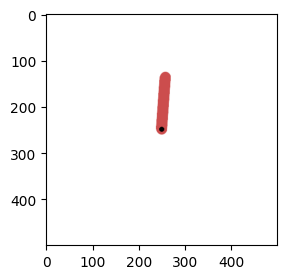

183.81251913645426

In [10]:
play(True)[-1]